# **Data Abstraction Workflow**

## Importing the required libraries

In [5]:
import pandas as pd # Pandas is used for data analysis and manipulation, providing data structures like DataFrames.
import numpy as np # NumPy provides support for numerical operations and array manipulations.
import geopandas as gpd # GeoPandas extends Pandas to handle geospatial data, enabling spatial operations.

from shapely import wkt, geometry # Shapely is used for manipulating geometric objects
from shapely.geometry import Point, MultiPolygon,Polygon, LineString, MultiLineString, box # Specific geometric shapes from Shapely are imported for spatial analysis.
from shapely.strtree import STRtree # STRtree is used for efficient spatial indexing and querying.

import networkx as nx # NetworkX is used for creating, manipulating, and studying complex networks.
from sklearn.cluster import DBSCAN # DBSCAN from scikit-learn is a density-based clustering algorithm.

from scipy.stats import mode # Mode function from SciPy's stats module is used to find the most frequent value in a dataset.
from scipy.spatial import Delaunay, cKDTree # Delaunay triangulation and cKDTree are used for spatial tessellation and efficient nearest neighbor search.
from math import degrees, atan2, pi # Math functions are imported for geometric calculations, such as angle computations.

import matplotlib.pyplot as plt  # Matplotlib is used for creating visualizations in Python.
import matplotlib.colors as mcolors # mcolors provides colormaps and utilities for working with colors in Matplotlib plots.
import folium  # Folium is used for creating interactive maps that can be displayed in web browsers.

##Initial loading of building footprint data for Nairobi

In [7]:
# Load the CSV file downloaded from Open Buildings using WKT by specifying an Nairobi area in WKT format
file_path = 'open_buildings_v3_polygons_your_own_wkt_polygon.csv'
data = pd.read_csv(file_path)

# Convert the 'geometry' column from WKT format to Shapely geometries
data['geometry'] = data['geometry'].apply(wkt.loads)

#Create a Geo DataFrame of the building footprint data
gdf = gpd.GeoDataFrame(data, geometry='geometry')

gdf.head()

latitude  longitude  area_in_meters  confidence  \
0 -1.202541  36.881486         34.9328      0.7461   
1 -1.332171  36.858919         14.0811      0.7801   
2 -1.194113  36.910146         41.5347      0.8241   
3 -1.248877  36.885837         94.2778      0.7643   
4 -1.290072  36.737170          7.3208      0.7428   

                                            geometry full_plus_code  
0  POLYGON ((36.88152 -1.20256, 36.8815 -1.2025, ...  6GCRQVWJ+XHQ8  
1  POLYGON ((36.85894 -1.33216, 36.85891 -1.33215...  6GCRMV95+4HM3  
2  POLYGON ((36.91019 -1.19411, 36.91014 -1.19407...  6GCRRW46+932G  
3  POLYGON ((36.88589 -1.24885, 36.88579 -1.24884...  6GCRQV2P+C8WX  
4  POLYGON ((36.73718 -1.29009, 36.73718 -1.29006...  6GCRPP5P+XVF3

##Checking and setting the CRS

In [8]:
# Check the current CRS
current_crs = gdf.crs
print("Current CRS:", current_crs)

# If CRS is not set, define it
if current_crs is None:
    gdf.crs = {'init': 'epsg:4326'}
    print("CRS has been set to:", gdf.crs)

#Covert to the EPSG code the allows for distance calculation
gdf = gdf.to_crs(epsg=32737)

Current CRS: None
CRS has been set to: +init=epsg:4326 +type=crs


/usr/local/lib/python3.10/dist-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


##Calculating the Building level features

###Feature 1: Building Footprint Area
- Calculate the area of each building footprint

In [9]:
# Rename the existing footprint area column from the Open buildings dataset
gdf.rename(columns = {'area_in_meters':'area'}, inplace = True)

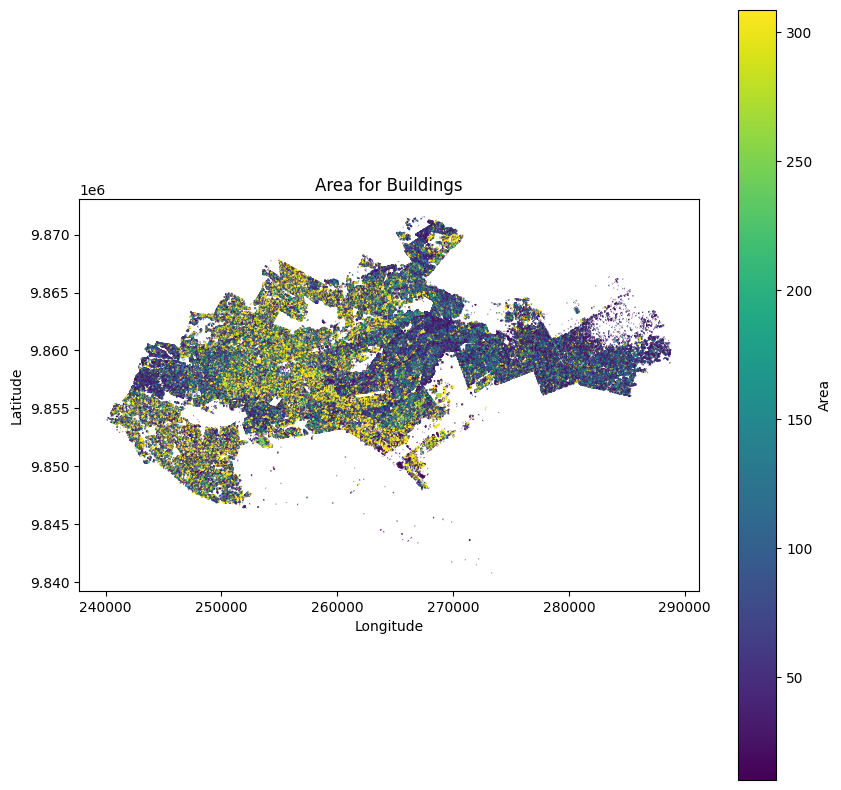

In [10]:
#Visualise the metric
# Map the area to colors with adjusted range for better variation
vmin, vmax = gdf['area'].quantile([0.05, 0.95])
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
cmap = plt.cm.viridis
gdf['edgecolor'] = gdf['area'].apply(lambda x: mcolors.to_hex(cmap(norm(x))))

# Visualize Area
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax, facecolor='none', edgecolor=gdf['edgecolor'], linewidth=1)
plt.title('Area for Buildings')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, label='Area')
plt.show()

###Feature 2: Building Perimeter
- Calculate the perimeter of each building footprint.

In [ ]:
# Calculate building perimeters
gdf['perimeter'] = gdf.geometry.length

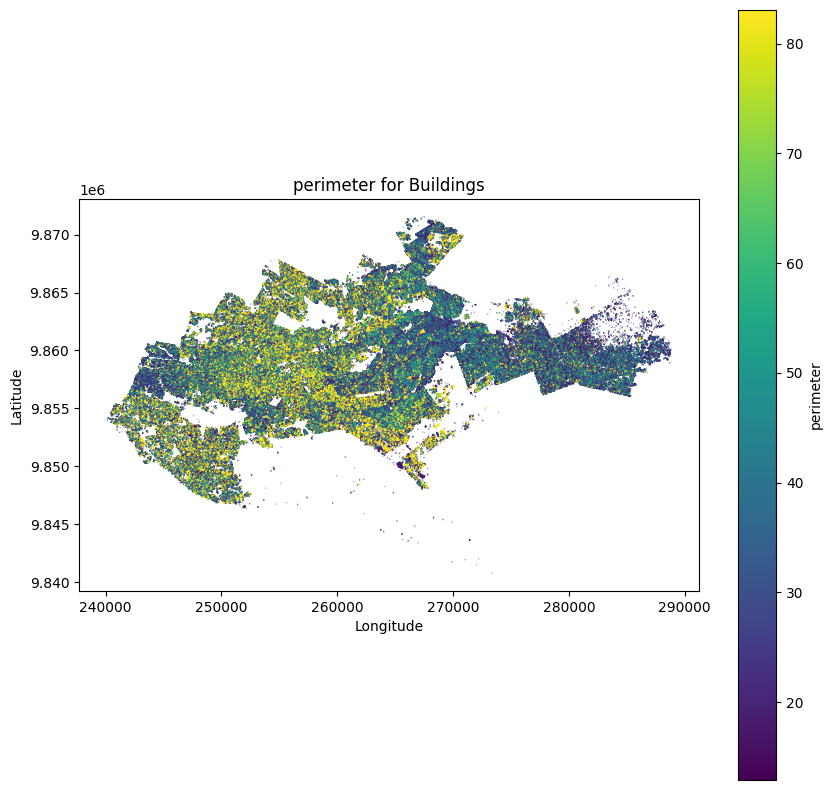

In [ ]:
# Map the perimeter to colors with adjusted range for better variation
vmin, vmax = gdf['perimeter'].quantile([0.05, 0.95])
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
cmap = plt.cm.viridis
gdf['edgecolor'] = gdf['perimeter'].apply(lambda x: mcolors.to_hex(cmap(norm(x))))

# Visualize perimeter
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax, facecolor='none', edgecolor=gdf['edgecolor'], linewidth=1)
plt.title('perimeter for Buildings')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, label='perimeter')
plt.show()

###Feature 3: Length of Facades
- Calculate the lengths of the long and short sides of each building.

In [ ]:
#Function to caculate facade lengths
def calculate_facade_lengths(geometry):
    if geometry.is_empty:
        return 0, 0  # Return zeros for empty geometries

    def get_lengths(polygon):
        coords = list(polygon.exterior.coords)
        if len(coords) < 2:
            return [0]  # Return zero if not enough points to form a segment
        lengths = [np.linalg.norm(np.array(coords[i]) - np.array(coords[i-1])) for i in range(1, len(coords))]
        return lengths

    lengths = []
    if isinstance(geometry, Polygon):
        lengths.extend(get_lengths(geometry))
    elif isinstance(geometry, MultiPolygon):
        for poly in geometry.geoms:
            lengths.extend(get_lengths(poly))

    if len(lengths) < 2:
        return 0, 0  # Return zeros if there are not enough lengths to determine two longest sides

    lengths.sort()
    return lengths[-1], lengths[-2]

# Calculate facade lengths
gdf['long_side'], gdf['short_side'] = zip(*gdf.geometry.apply(calculate_facade_lengths))

# Display the result
gdf[['long_side', 'short_side']].head()

long_side  short_side
0   6.313950    6.313950
1   3.748760    3.748760
2   6.631579    6.631579
3  12.013814   12.013814
4   3.006944    3.006944

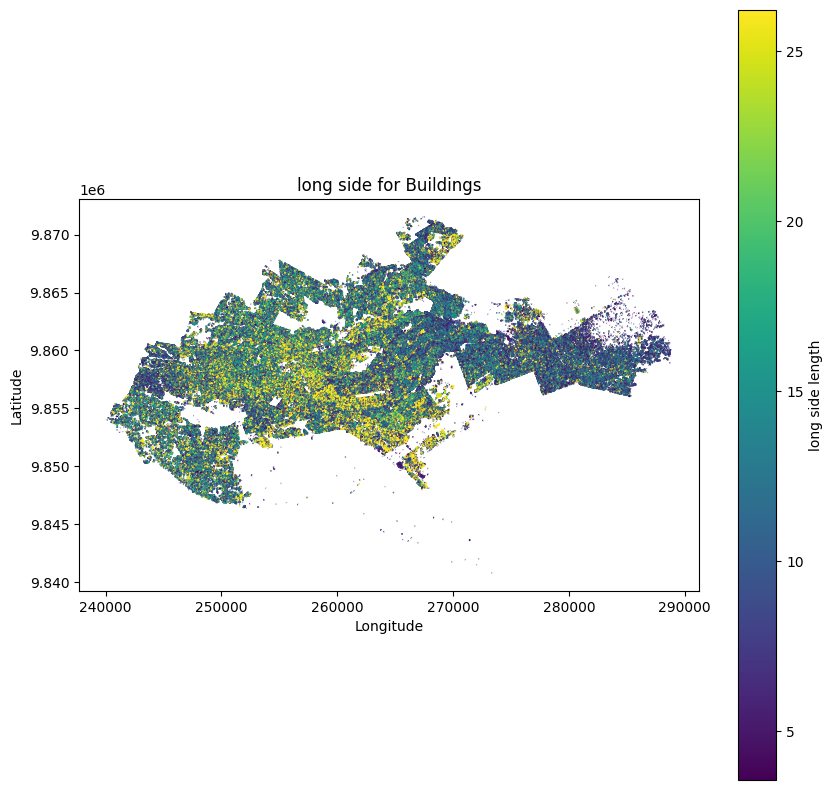

In [ ]:
# Map the long side to colors with adjusted range for better variation
vmin, vmax = gdf['long_side'].quantile([0.05, 0.95])
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
cmap = plt.cm.viridis
gdf['edgecolor'] = gdf['long_side'].apply(lambda x: mcolors.to_hex(cmap(norm(x))))

# Visualize long side length
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax, facecolor='none', edgecolor=gdf['edgecolor'], linewidth=1)
plt.title('long side for Buildings')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, label='long side length')
plt.show()

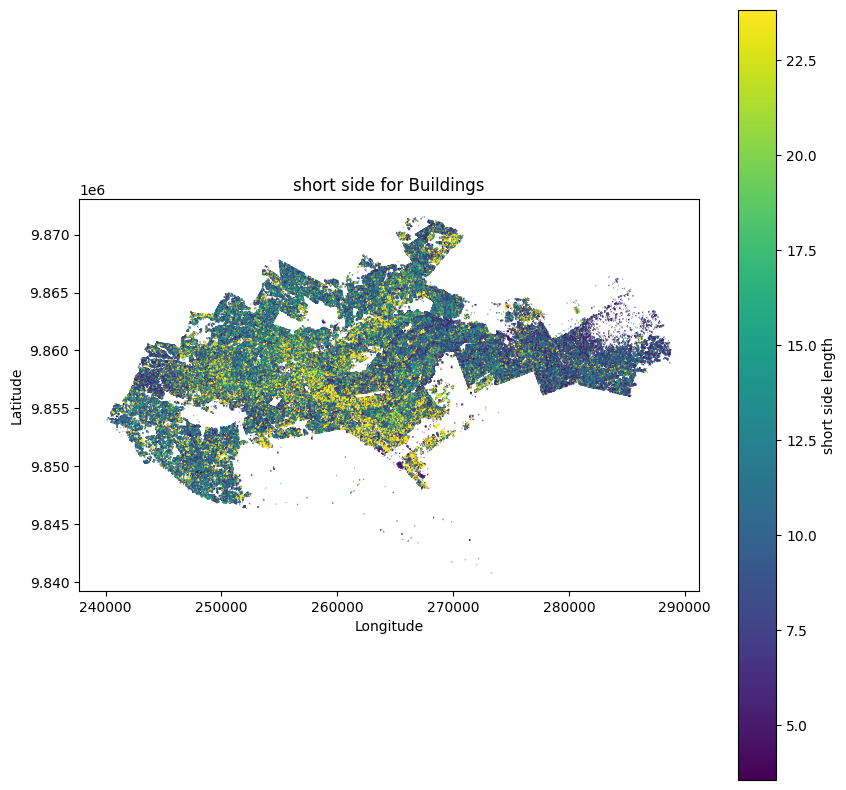

In [ ]:
# Map the long side to colors with adjusted range for better variation
vmin, vmax = gdf['short_side'].quantile([0.05, 0.95])
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
cmap = plt.cm.viridis
gdf['edgecolor'] = gdf['short_side'].apply(lambda x: mcolors.to_hex(cmap(norm(x))))

# Visualize short side length
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax, facecolor='none', edgecolor=gdf['edgecolor'], linewidth=1)
plt.title('short side for Buildings')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, label='short side length')
plt.show()

###Feature 4: Number of Vertices
- Calculate the number of vertices for each building.

In [ ]:
# Calculate the number of vertices for each building
gdf['num_vertices'] = gdf.geometry.apply(lambda x: len(x.exterior.coords) if x.geom_type == 'Polygon' else 0)

# Calculate average number of vertices
average_vertices = gdf['num_vertices'].mean()
print(f"Average number of vertices: {average_vertices}")

Average number of vertices: 5.619785762095649


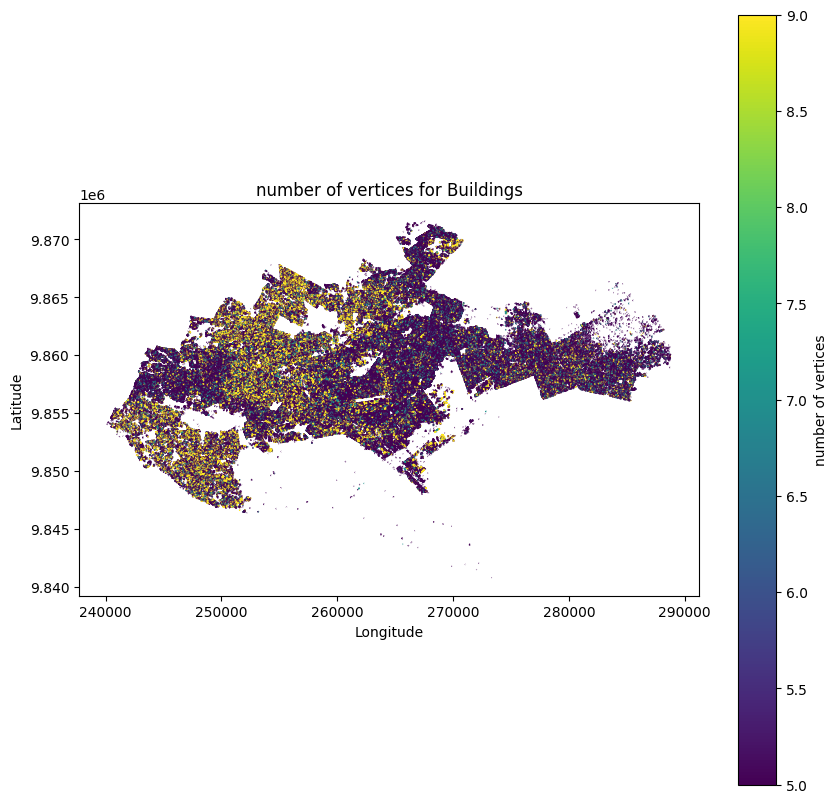

In [ ]:
# Map the number of vertices to colors with adjusted range for better variation
vmin, vmax = gdf['num_vertices'].quantile([0.05, 0.95])
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
cmap = plt.cm.viridis
gdf['edgecolor'] = gdf['num_vertices'].apply(lambda x: mcolors.to_hex(cmap(norm(x))))

# Visualize number of vertices
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax, facecolor='none', edgecolor=gdf['edgecolor'], linewidth=1)
plt.title('number of vertices for Buildings')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, label='number of vertices')
plt.show()

###Feature 5: Proximity of Buildings
- The centroids of the building footprints are extracted for distance calculations.
- KDTree is created for efficient distance calculations, and the nearest neighbors are queried.
- The nearest neighbor distances are calculated and assigned to the GeoDataFrame.

In [ ]:
# Extract centroid coordinates for distance calculations
gdf['centroid'] = gdf.centroid
coords = np.vstack([gdf.centroid.x, gdf.centroid.y]).T

# Create a KDTree for efficient distance calculations
tree = cKDTree(coords)

# Query the nearest neighbors
distances, _ = tree.query(coords, k=2)  # k=2 to get the nearest neighbor excluding itself

# The nearest neighbor distance is the second column of the result
nearest_distances = distances[:, 1]
gdf['nearest_distance'] = nearest_distances

# Calculate average distance to nearest neighbors
average_distance = gdf['nearest_distance'].mean()
print(f"Average distance to nearest neighbors: {average_distance}")

Average distance to nearest neighbors: 9.834742182524232


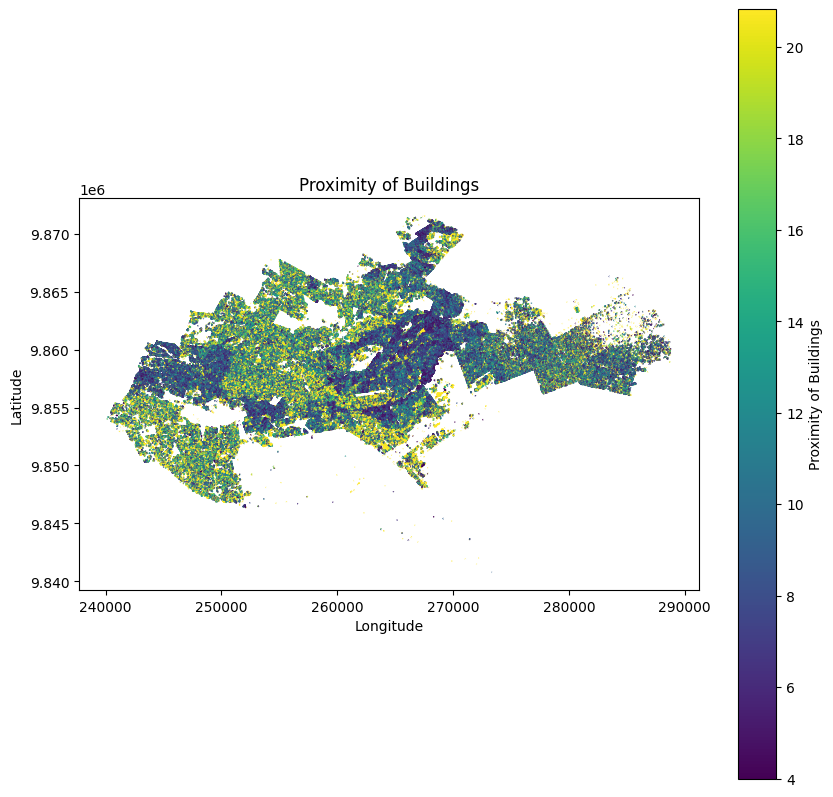

In [ ]:
# Map the Proximity of Buildings to colors with adjusted range for better variation
vmin, vmax = gdf['nearest_distance'].quantile([0.05, 0.95])
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
cmap = plt.cm.viridis
gdf['edgecolor'] = gdf['nearest_distance'].apply(lambda x: mcolors.to_hex(cmap(norm(x))))

# Visualize Proximity of Buildings
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax, facecolor='none', edgecolor=gdf['edgecolor'], linewidth=1)
plt.title('Proximity of Buildings')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, label='Proximity of Buildings')
plt.show()

###Feature 6: Shape Complexity Index

- Calculate the perimeter and area for each building.
- Compute the Shape Complexity Index as the ratio of perimeter to area.

In [ ]:
# Calculate the Shape Complexity Index as the ratio of perimeter to area
gdf['shape_complexity_index'] = gdf['perimeter'] / gdf['area']

# Calculate average Shape Complexity Index
average_sci = gdf['shape_complexity_index'].mean()
print(f"Average Shape Complexity Index: {average_sci}")

Average Shape Complexity Index: 0.6530720931120549


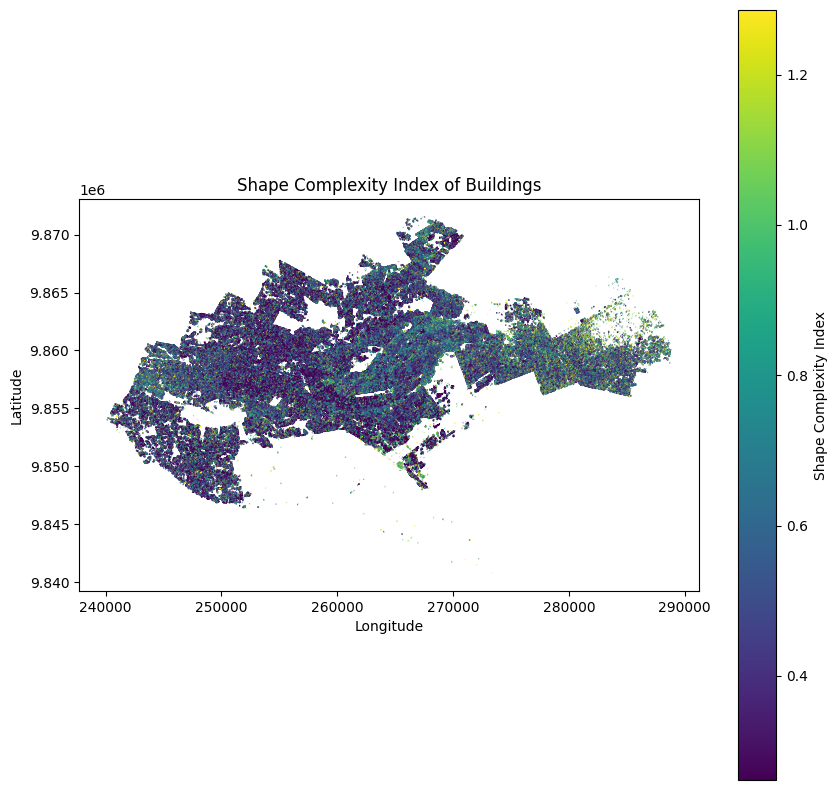

In [ ]:
# Map the Shape Complexity Index of Buildings to colors with adjusted range for better variation
vmin, vmax = gdf['shape_complexity_index'].quantile([0.05, 0.95])
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
cmap = plt.cm.viridis
gdf['edgecolor'] = gdf['shape_complexity_index'].apply(lambda x: mcolors.to_hex(cmap(norm(x))))

# Visualize Shape Complexity Index of Buildings
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax, facecolor='none', edgecolor=gdf['edgecolor'], linewidth=1)
plt.title('Shape Complexity Index of Buildings')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, label='Shape Complexity Index')
plt.show()

###Feature 7: Shape Compactness Index
- Compute Shape Compactness Index
- Compactness Index = $(4π * Area)/Perimeter^2$

In [ ]:
# Calculate the Shape Compactness Index as the ratio of area to perimeter squared
gdf['shape_compactness_index'] = (4 * np.pi * gdf['area']) / (gdf['perimeter'] ** 2)

# Calculate average Shape Compactness Index
average_sci = gdf['shape_compactness_index'].mean()
print(f"Average Shape Compactness Index: {average_sci}")


Average Shape Compactness Index: 0.6907586375101374


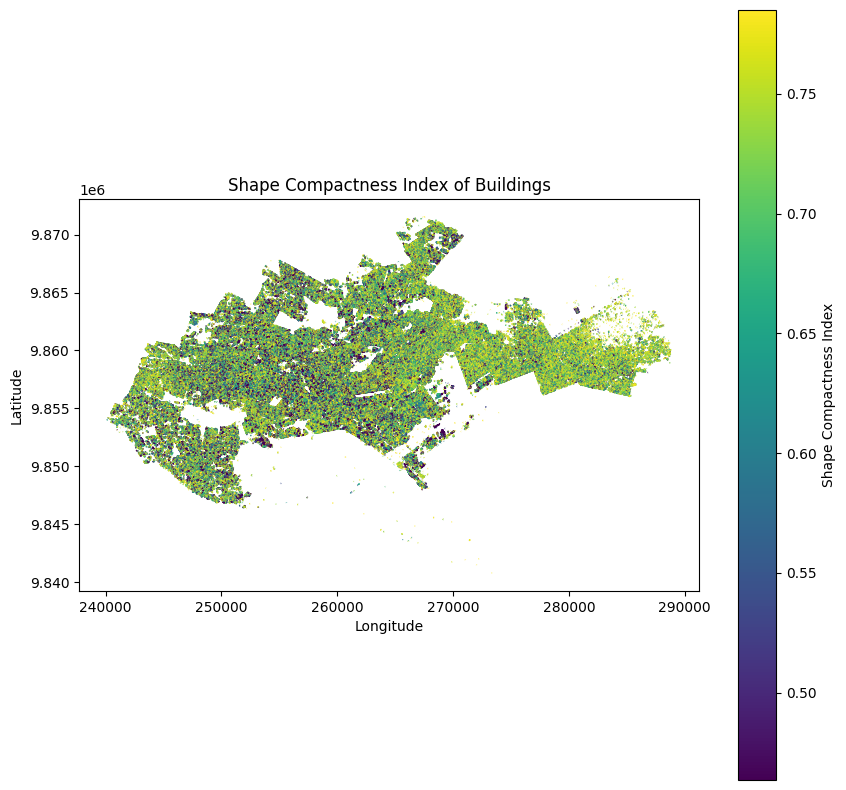

In [ ]:
# Map the Shape Compactness Index of Buildings to colors with adjusted range for better variation
vmin, vmax = gdf['shape_compactness_index'].quantile([0.05, 0.95])
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
cmap = plt.cm.viridis
gdf['edgecolor'] = gdf['shape_compactness_index'].apply(lambda x: mcolors.to_hex(cmap(norm(x))))

# Visualize Shape Compactness Index of Buildings
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax, facecolor='none', edgecolor=gdf['edgecolor'], linewidth=1)
plt.title('Shape Compactness Index of Buildings')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, label='Shape Compactness Index')
plt.show()

###Feature 8: Equivalent Rectangular Index
- Compute the dimensions of the equivalent rectangle from area for each building
- Calculate the perimeter of the equivalent rectangle
- Compute the Equivalent Rectangular Index as the ratio of the building footprint's perimeter to the perimeter of the equivalent rectangle.

In [ ]:
# Calculate the dimensions of the equivalent rectangle
gdf['equivalent_rectangle_length'] = np.sqrt(gdf['area'])
gdf['equivalent_rectangle_width'] = gdf['area'] / gdf['equivalent_rectangle_length']

# Calculate the perimeter of the equivalent rectangle
gdf['equivalent_rectangle_perimeter'] = 2 * (gdf['equivalent_rectangle_length'] + gdf['equivalent_rectangle_width'])

# Calculate the Equivalent Rectangular Index (ERI)
gdf['equivalent_rectangular_index'] = gdf['perimeter'] / gdf['equivalent_rectangle_perimeter']

# Calculate average Equivalent Rectangular Index
average_eri = gdf['equivalent_rectangular_index'].mean()
print(f"Average Equivalent Rectangular Index: {average_eri}")


Average Equivalent Rectangular Index: 1.0793842207062951


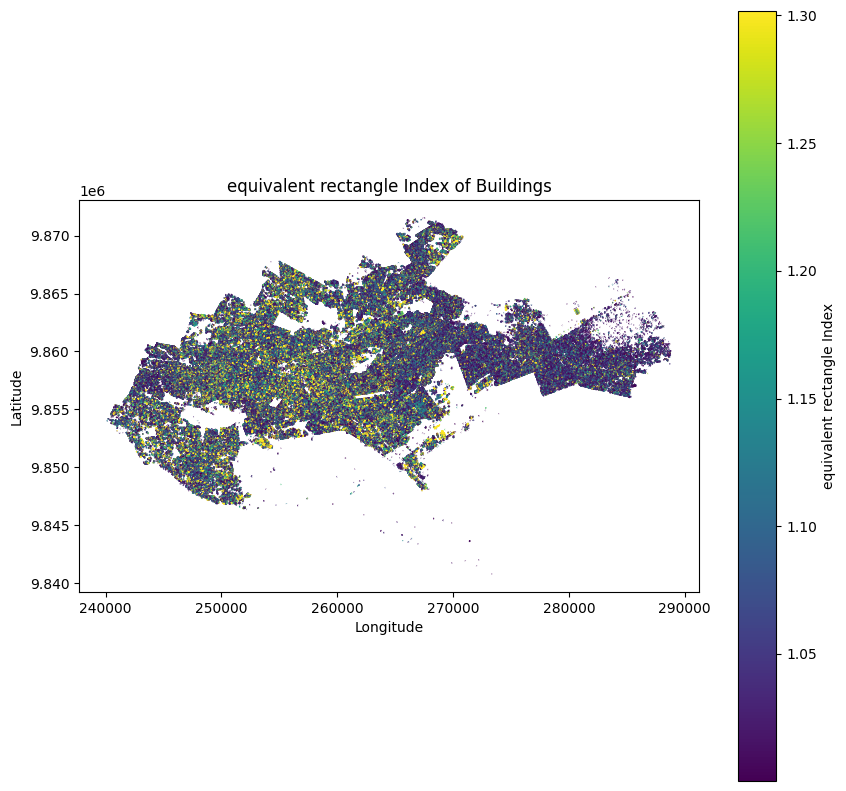

In [ ]:
# Map the equivalent rectangle Index of Buildings to colors with adjusted range for better variation
vmin, vmax = gdf['equivalent_rectangular_index'].quantile([0.05, 0.95])
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
cmap = plt.cm.viridis
gdf['edgecolor'] = gdf['equivalent_rectangular_index'].apply(lambda x: mcolors.to_hex(cmap(norm(x))))

# Visualize equivalent rectangle Index of Buildings
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax, facecolor='none', edgecolor=gdf['edgecolor'], linewidth=1)
plt.title('equivalent rectangle Index of Buildings')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, label='equivalent rectangle Index')
plt.show()

###Feature 9: Inner Irregularity
- Calculate Internal angles for each polygon, the internal angles at each corner are calculated using vector math. The angle is adjusted to fall between 0 and 180 degrees.
- The irregularity index is computed as the ratio of the standard deviation to the mean of the internal angles.

In [ ]:
# Function to calculate internal angles of a polygon
def calculate_internal_angles(polygon):
    coords = list(polygon.exterior.coords)
    n = len(coords) - 1  # Last point is the same as the first point
    angles = []
    for i in range(n):
        p1 = coords[i]
        p2 = coords[(i + 1) % n]
        p3 = coords[(i + 2) % n]
        v1 = (p1[0] - p2[0], p1[1] - p2[1])
        v2 = (p3[0] - p2[0], p3[1] - p2[1])
        angle = degrees(atan2(v2[1], v2[0]) - atan2(v1[1], v1[0]))
        if angle < 0:
            angle += 360
        if angle > 180:
            angle = 360 - angle
        angles.append(angle)
    return angles

# Calculate the internal angles and irregularity index for each building
def irregularity_index(angles):
    return np.std(angles) / np.mean(angles)

gdf['internal_angles'] = gdf.geometry.apply(lambda x: calculate_internal_angles(x) if x.geom_type == 'Polygon' else [])
gdf['irregularity_index'] = gdf['internal_angles'].apply(lambda x: irregularity_index(x) if x else 0)

# Calculate average Inner Irregularity index
average_irregularity_index = gdf['irregularity_index'].mean()
print(f"Average Inner Irregularity Index: {average_irregularity_index}")


Average Inner Irregularity Index: 0.00328154576637832


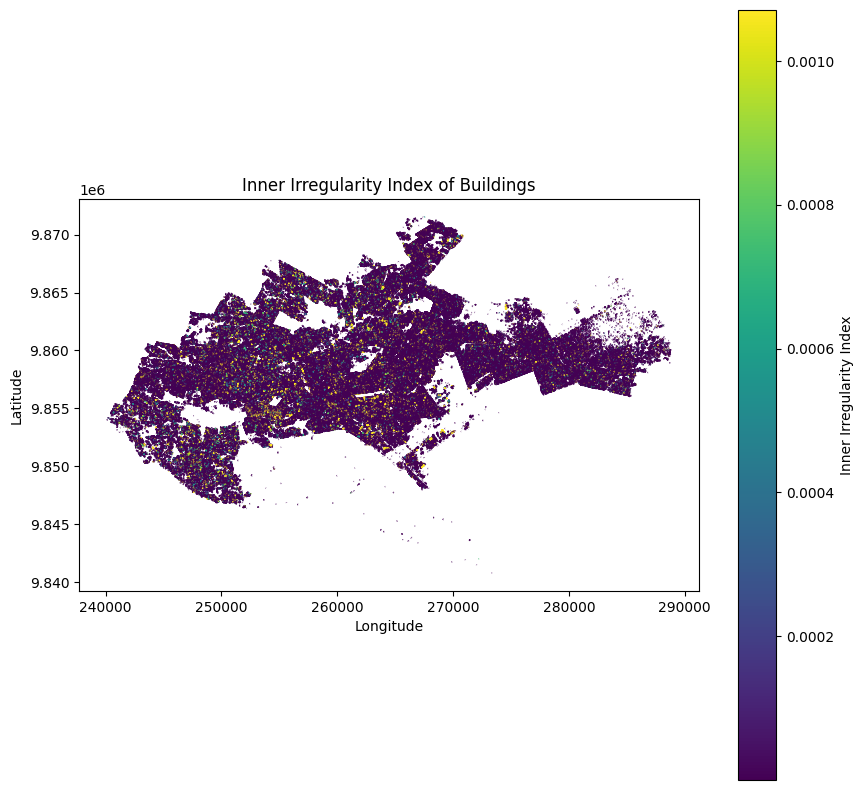

In [ ]:
# Map the Inner Irregularity Index of Buildings to colors with adjusted range for better variation
vmin, vmax = gdf['irregularity_index'].quantile([0.05, 0.95])
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
cmap = plt.cm.viridis
gdf['edgecolor'] = gdf['irregularity_index'].apply(lambda x: mcolors.to_hex(cmap(norm(x))))

# Visualize Inner Irregularity Index of Buildings
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax, facecolor='none', edgecolor=gdf['edgecolor'], linewidth=1)
plt.title('Inner Irregularity Index of Buildings')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, label='Inner Irregularity Index')
plt.show()

###Feature 10: Directionality
- Generate Delaunay Triangulation using the filtered vertices of closest edges between adjacent buildings.
- Filter out triangles whose centroids lie within any building footprint.
- Calculate internal angles of triangle and the orientation index for each triangle.
- Orientation index: Calculate the directionality index for each triangle using the shortest side angles.
- Directionality index: Map each vertex to the directionality index of the triangle it belongs to. Calculate the directionality index for each building based on the average index of its vertices.

In [ ]:
# Extract edge vertices from building footprints
vertices = []
for geom in gdf.geometry:
    if geom.geom_type == 'Polygon':
        vertices.extend(list(geom.exterior.coords))

vertices = np.array(vertices)

# Create a KDTree for efficient nearest neighbor search
tree = cKDTree(vertices)

# Find closest edges between adjacent buildings
edges = set()
for i, vertex in enumerate(vertices):
    dists, indices = tree.query(vertex, k=10)  # Check the 10 closest vertices to find the closest edge
    for dist, index in zip(dists, indices):
        if dist > 0 and i != index:  # Avoid self-loops
            edge = tuple(sorted((i, index)))
            edges.add(edge)

# Extract unique vertices from the edges
unique_vertex_indices = np.unique(np.array(list(edges)).flatten())
filtered_vertices = vertices[unique_vertex_indices]

# Generate Delaunay Triangulation using filtered vertices
tri = Delaunay(filtered_vertices)

# Create spatial index for building geometries
building_tree = STRtree(gdf.geometry)

# Filter triangles that have centroids within any building footprint
def triangle_in_building(triangle, building_tree):
    tri_polygon = Polygon(triangle)
    return any(building_tree.query(tri_polygon.centroid))

filtered_triangles = []
for simplex in tri.simplices:
    triangle = filtered_vertices[simplex]
    if not triangle_in_building(triangle, building_tree):
        filtered_triangles.append(simplex)

filtered_triangles = np.array(filtered_triangles)

# Calculate internal angles of triangles
def calculate_internal_angles(triangle):
    angles = []
    for i in range(3):
        p1 = triangle[i]
        p2 = triangle[(i + 1) % 3]
        p3 = triangle[(i + 2) % 3]
        v1 = p2 - p1
        v2 = p3 - p1
        angle = np.degrees(np.arccos(np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))))
        angles.append(angle)
    return angles

# Calculate orientation index for each triangle
def calculate_orientation_index(angles):
    oi_values = [1 - abs(angle - 45) / 45 for angle in angles]
    return np.mean(oi_values)

# Calculate directionality index for each triangle
directionality_indices = []
for simplex in filtered_triangles:
    triangle = filtered_vertices[simplex]
    angles = calculate_internal_angles(triangle)
    shortest_side_index = np.argmin([np.linalg.norm(triangle[(i + 1) % 3] - triangle[i]) for i in range(3)])
    shortest_side_angles = [angles[shortest_side_index], angles[(shortest_side_index + 1) % 3]]
    orientation_index = calculate_orientation_index(shortest_side_angles)
    directionality_indices.append(orientation_index)

# Create a mapping from each vertex to the directionality index of the triangle it belongs to
vertex_to_index = {tuple(filtered_vertices[simplex[i]]): directionality_indices[j]
                   for j, simplex in enumerate(filtered_triangles)
                   for i in range(3)}

# Calculate the directionality index for each building based on the average index of its vertices
def calculate_building_directionality(geometry):
    if geometry.geom_type == 'Polygon':
        vertices = list(geometry.exterior.coords)
        indices = [vertex_to_index.get(tuple(v), 0) for v in vertices]
        return np.mean(indices)
    return 0

gdf['directionality_index'] = gdf.geometry.apply(calculate_building_directionality)

# Calculate average Directionality index
average_directionality_index = gdf['directionality_index'].mean()
print(f"Average Directionality Index: {average_directionality_index}")

/var/folders/3b/psmklz1j6sz4ssxf0c6vcl600000gn/T/ipykernel_12341/3487009879.py:56: RuntimeWarning: invalid value encountered in arccos
  angle = np.degrees(np.arccos(np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))))


Average Directionality Index: 0.15681041995072342


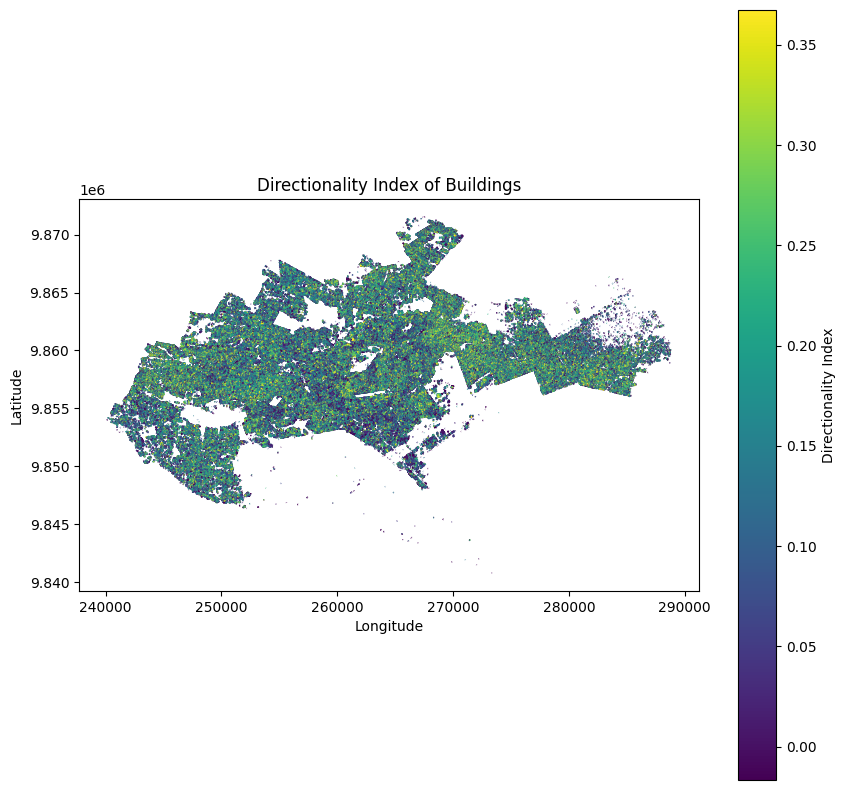

In [ ]:
# Map the Directionality Index of Buildings to colors with adjusted range for better variation
vmin, vmax = gdf['directionality_index'].quantile([0.05, 0.95])
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
cmap = plt.cm.viridis
gdf['edgecolor'] = gdf['directionality_index'].apply(lambda x: mcolors.to_hex(cmap(norm(x))))

# Visualize Directionality Index of Buildings
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax, facecolor='none', edgecolor=gdf['edgecolor'], linewidth=1)
plt.title('Directionality Index of Buildings')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, label='Directionality Index')
plt.show()

###Feature 11: Distance between vertex and nearest façade (dvl) mean

Extract Vertices from Each Building:

* Identify the vertices (corners) of each building polygon.

* Calculate Distances:
For each vertex, calculate the perpendicular (orthogonal) distance to the nearest façade (edge) of any other building.

* Compute Mean Distance:
Compute the mean distance for all vertices of each building.

In [ ]:
# Function to extract vertices from a polygon or multipolygon
def extract_vertices(geometry):
    vertices = []
    if geometry.geom_type == 'Polygon':
        vertices.extend(geometry.exterior.coords)
    elif geometry.geom_type == 'MultiPolygon':
        for polygon in geometry.geoms:
            vertices.extend(polygon.exterior.coords)
    return vertices

# Function to calculate the perpendicular distance from a point to a line
def perpendicular_distance(point, line):
    return point.distance(line.interpolate(line.project(point)))

# Function to calculate mean dvl for each building using spatial index
def calculate_mean_dvl(building_idx, building_geometry, tree, all_geometries):
    vertices = extract_vertices(building_geometry)
    distances = []
    point_objects = [Point(vertex) for vertex in vertices]

    # Query nearby buildings using spatial index
    nearby_building_indices = tree.query(building_geometry)

    for point in point_objects:
        min_distance = float('inf')
        for other_building_idx in nearby_building_indices:
            if other_building_idx == building_idx:
                continue
            other_building = all_geometries[other_building_idx]
            if other_building.geom_type == 'Polygon':
                polygons = [other_building]
            elif other_building.geom_type == 'MultiPolygon':
                polygons = list(other_building.geoms)
            else:
                continue
            for polygon in polygons:
                coords = list(polygon.exterior.coords)
                for i in range(len(coords) - 1):
                    line = LineString([coords[i], coords[i + 1]])
                    distance = perpendicular_distance(point, line)
                    if distance < min_distance:
                        min_distance = distance
        distances.append(min_distance)

    return np.mean(distances) if distances else np.nan

# Build a spatial index for all building geometries
all_geometries = list(gdf.geometry)
tree = STRtree(all_geometries)

# Calculate mean dvl for each building using spatial index
mean_dvls = []
for idx, geom in enumerate(gdf.geometry):
    if geom.geom_type in ['Polygon', 'MultiPolygon']:
        mean_dvl = calculate_mean_dvl(idx, geom, tree, all_geometries)
    else:
        mean_dvl = np.nan
    mean_dvls.append(mean_dvl)

# Store the results in the GeoDataFrame
gdf['dvl_mean'] = mean_dvls

In [ ]:
#replace inf with nan for downstream analysis
gdf['dvl_mean'] = gdf['dvl_mean'].replace([np.inf, -np.inf], np.nan)

###Feature 12: Orientation index mean
Measure the alignment of the buildings relative to a reference direction

* Extract the Orientation of Each Building: Determine the orientation of the longest side of each building polygon.

* Calculate the Orientation Index: The orientation index for each building is calculated using the formula: $ 1 - \left| \Delta O - 45^\circ \right| \cdot \frac{1}{45} \ $
O is the angle of the building's orientation relative to the north-south axis.


In [ ]:
# Function to extract the longest side and its orientation from a polygon or multipolygon
def calculate_orientation(geometry):
    max_length = 0
    orientation = 0
    if geometry.geom_type == 'Polygon':
        coords = list(geometry.exterior.coords)
        for i in range(len(coords) - 1):
            p1 = Point(coords[i])
            p2 = Point(coords[i + 1])
            length = p1.distance(p2)
            if length > max_length:
                max_length = length
                orientation = np.degrees(np.arctan2(p2.y - p1.y, p2.x - p1.x))
    elif geometry.geom_type == 'MultiPolygon':
        for polygon in geometry.geoms:
            coords = list(polygon.exterior.coords)
            for i in range(len(coords) - 1):
                p1 = Point(coords[i])
                p2 = Point(coords[i + 1])
                length = p1.distance(p2)
                if length > max_length:
                    max_length = length
                    orientation = np.degrees(np.arctan2(p2.y - p1.y, p2.x - p1.x))
    return orientation

# Function to calculate the orientation index for a given angle relative to 45 degrees
def calculate_orientation_index(angle):
    return 1 - (abs(angle - 45) / 45)

# Calculate the mean orientation index for each building
orientation_indices = []

for geom in gdf.geometry:
    orientation = calculate_orientation(geom)
    orientation_index = calculate_orientation_index(orientation)
    orientation_indices.append(orientation_index)

# Store the results in the GeoDataFrame
gdf['orientation_index_mean'] = orientation_indices

### Feature 13: Internal Angle Irregularity:
* Extract Internal Angles:
Calculate internal angles for each vertex in the polygon.
* Calculate Deviations:
Determine the deviation of each angle from the expected angle.
* Calculate inner regualrity: $ \frac{\max(\theta_1, \ldots, \theta_N) - \min(\theta_1, \ldots, \theta_N)}{\frac{\sum_{i=1}^{N} \theta_i}{N}}
 $


In [ ]:
# Function to calculate internal angles of a polygon
def calculate_internal_angles(coords):
    angles = []
    n = len(coords) - 1  # subtract one because the first and last point are the same
    for i in range(1, n):
        p0 = np.array(coords[i - 1])
        p1 = np.array(coords[i])
        p2 = np.array(coords[i + 1])

        v0 = p0 - p1
        v1 = p2 - p1

        angle = degrees(atan2(np.linalg.det([v0, v1]), np.dot(v0, v1)))
        angles.append(angle if angle > 0 else angle + 360)
    return angles

# Function to calculate internal angle irregularity
def calculate_internal_angle_irregularity(geometry):
    if geometry.geom_type == 'Polygon':
        coords = list(geometry.exterior.coords)
        angles = calculate_internal_angles(coords)
    elif geometry.geom_type == 'MultiPolygon':
        angles = []
        for polygon in geometry.geoms:
            coords = list(polygon.exterior.coords)
            angles.extend(calculate_internal_angles(coords))
    else:
        return 0

    # Calculate deviation from 90 degrees
    deviations = np.abs(np.array(angles) - 90)
    return np.std(deviations) if len(deviations) > 0 else 0

# Calculate internal angle irregularity for each building
gdf['internal_angle_irregularity'] = gdf['geometry'].apply(calculate_internal_angle_irregularity)

###Feature 14: Mean Length of DT (Delaunay Triangulation) Long Sides

* Extract Vertices: Extract vertices of the building footprints.

* Compute Delaunay Triangulation: Use the Delaunay triangulation to create triangles connecting the vertices.

* Calculate Long Side Lengths: Determine the lengths of the sides of the triangles and identify the long sides.

* Compute Mean Length of Long Sides: Calculate the mean length of these long sides.



###Feature 15: Angle between DT long sides

* Calculate Angles Between Long Sides: Calculate the angles between the long sides of adjacent triangles


In [ ]:
# Function to extract vertices from a polygon or multipolygon
def extract_vertices(geometry):
    vertices = []
    if geometry.geom_type == 'Polygon':
        vertices.extend(geometry.exterior.coords)
    elif geometry.geom_type == 'MultiPolygon':
        for polygon in geometry.geoms:
            vertices.extend(polygon.exterior.coords)
    return vertices

# Function to calculate the length of a line segment
def calculate_length(p1, p2):
    return np.linalg.norm(np.array(p1) - np.array(p2))

# Function to calculate the angle between two vectors
def calculate_angle(v1, v2):
    unit_vector_1 = v1 / np.linalg.norm(v1)
    unit_vector_2 = v2 / np.linalg.norm(v2)
    dot_product = np.dot(unit_vector_1, unit_vector_2)
    # Clip the dot product to the range [-1, 1] to avoid invalid values for arccos
    dot_product = np.clip(dot_product, -1.0, 1.0)
    angle = np.arccos(dot_product)
    return np.degrees(angle)

# Function to find the long sides in Delaunay triangles
def find_long_sides_and_angles(vertices):
    tri = Delaunay(vertices)
    long_sides = []
    angles_between_long_sides = []
    for simplex in tri.simplices:
        p1, p2, p3 = vertices[simplex]
        lengths = [
            calculate_length(p1, p2),
            calculate_length(p2, p3),
            calculate_length(p3, p1)
        ]
        long_side_index = np.argmax(lengths)
        if long_side_index == 0:
            long_side_1 = p1 - p2
            long_side_2 = p3 - p1
        elif long_side_index == 1:
            long_side_1 = p2 - p3
            long_side_2 = p1 - p2
        else:
            long_side_1 = p3 - p1
            long_side_2 = p2 - p3
        angle = calculate_angle(long_side_1, long_side_2)
        long_sides.append(max(lengths))
        angles_between_long_sides.append(angle)
    return long_sides, angles_between_long_sides

# Calculate the metrics for each building
mean_lengths = []
mean_angles = []

for geom in gdf.geometry:
    vertices = np.array(extract_vertices(geom))
    if len(vertices) < 3:  # Skip buildings with less than 3 vertices
        mean_lengths.append(np.nan)
        mean_angles.append(np.nan)
        continue

    # Create a KDTree for the building vertices
    tree = cKDTree(vertices)

    # Use KDTree to find unique vertices from the edges
    ball_tree_indices = tree.query_ball_tree(tree, r=1e-9)
    flat_indices = np.unique([item for sublist in ball_tree_indices for item in sublist])
    filtered_vertices = vertices[flat_indices]

    # Find long sides and angles using the filtered unique vertices
    long_sides, angles_between_long_sides = find_long_sides_and_angles(filtered_vertices)

    # Calculate mean values
    mean_lengths.append(np.mean(long_sides) if long_sides else np.nan)
    mean_angles.append(np.mean(angles_between_long_sides) if angles_between_long_sides else np.nan)

# Store the results in the GeoDataFrame
gdf['mean_length_dt_long_sides'] = mean_lengths
gdf['mean_angle_between_dt_long_sides'] = mean_angles

## Create block definition

In [ ]:
# Load the accesibility shapefile
block_gpkg_path = 'Nairobi_Accessibility.gpkg'
block_gdf = gpd.read_file(block_gpkg_path)

# Ensure CRS is WGS84
block_gdf = block_gdf.to_crs(epsg=32737)


In [ ]:
#Create the block dataframe with the required columns from the accessiblity shapefile
block_gdf=block_gdf[['geometry', 'k_complexity', 'k_complexity_weighted_landscan_un']]

In [ ]:
#Calculate the centroid of the block for downstream analysis
block_gdf['centroid'] = block_gdf.geometry.centroid

In [ ]:
#Create a block level index column for spatial joins
block_gdf['block_id'] = block_gdf.index

In [ ]:
block_gdf.head()

geometry  k_complexity  \
0  MULTIPOLYGON (((264445.075 9844698.260, 264399...           1.0   
1  MULTIPOLYGON (((263495.575 9844687.338, 263499...           1.0   
2  MULTIPOLYGON (((263055.715 9844604.911, 263063...           1.0   
3  MULTIPOLYGON (((263090.138 9844575.842, 263094...           1.0   
4  MULTIPOLYGON (((263064.503 9844597.306, 263064...           1.0   

   k_complexity_weighted_landscan_un                        centroid  block_id  
0                           0.000000  POINT (264566.683 9844587.505)         0  
1                           0.070204  POINT (263646.224 9844702.072)         1  
2                           0.000000  POINT (263055.870 9844604.739)         2  
3                           0.000000  POINT (263101.297 9844574.279)         3  
4                           0.000000  POINT (263064.635 9844597.195)         4

In [ ]:
# Helper Funcion for mode calculation
def calculate_mode(series):
    series = series.dropna().astype(float)  # Ensure series is numeric and drop NaNs
    if series.empty:
        return np.nan
    m = mode(series)
    try:
        return m.mode[0] if len(m.mode) > 0 else np.nan
    except TypeError:  # Handle case where mode is a scalar
        return m.mode if m.count > 0 else np.nan

## Block level indicators calculation

### Feature 16: Building Density
- Perform a spatial join using building centroids and block cell polygon.
- Calculate the density for each cell.

In [ ]:
# Spatial join to count buildings in each cell
joined = gpd.sjoin(gdf.set_geometry('centroid'), block_gdf, how='left', predicate='within')

# Count buildings in each grid cell
building_counts = joined.groupby('index_right').size().reset_index(name='building_count')

# Merge the building counts back into the grid
block_gdf = block_gdf.reset_index().merge(building_counts, how='left', left_on='index', right_on='index_right').fillna(0)
block_gdf = block_gdf.drop(columns=['index_right'])

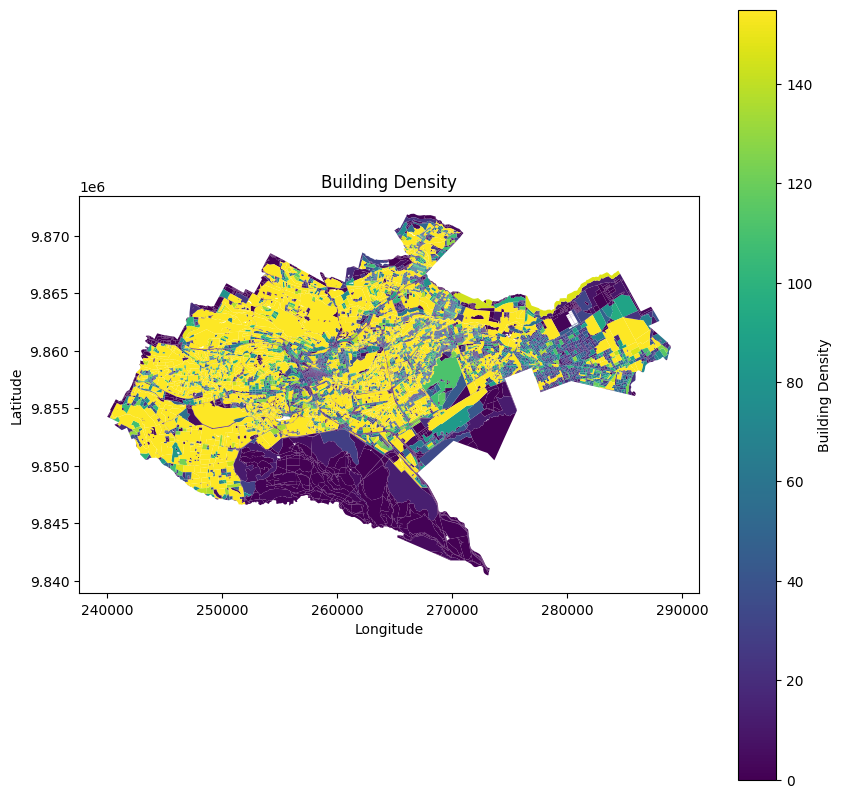

In [ ]:
# Map the Building Density to colors with adjusted range for better variation
vmin, vmax = block_gdf['building_count'].quantile([0.05, 0.95])
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
cmap = plt.cm.viridis
block_gdf['facecolor'] = block_gdf['building_count'].apply(lambda x: mcolors.to_hex(cmap(norm(x))))

# Visualize Building Density
fig, ax = plt.subplots(figsize=(10, 10))
block_gdf.plot(ax=ax, facecolor=block_gdf['facecolor'], edgecolor='none', linewidth=1)
plt.title('Building Density')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, label='Building Density')
plt.show()

## Aggregate building level metrics to grid level

In [ ]:
# Spatial join to assign building metrics to grid cells
join_result = gpd.sjoin(gdf.set_geometry('centroid'), block_gdf, how='left', predicate='within')

In [ ]:
# Aggregate the metrics
aggregated_metrics = join_result.groupby('index_right').agg({
    'area': ['mean','sum'],
    'perimeter': 'mean',
    'long_side': 'mean',
    'short_side': 'mean',
    'nearest_distance': 'mean',
    'num_vertices': 'mean',
    'shape_complexity_index': ['mean', 'median', calculate_mode],
    'shape_compactness_index': ['mean', 'median', calculate_mode],
    'equivalent_rectangular_index': ['mean', 'median', calculate_mode],
    'irregularity_index': ['mean', 'median', calculate_mode],
    'directionality_index': ['mean', 'median', calculate_mode],
    'dvl_mean' : 'mean',
    'orientation_index_mean' : 'mean',
    'internal_angle_irregularity' : 'max',
    'mean_length_dt_long_sides' : 'max',
    'mean_angle_between_dt_long_sides' : 'mean'
}).reset_index()

# Flatten the MultiIndex columns
aggregated_metrics.columns = ['_'.join(col).strip() if col[1] else col[0] for col in aggregated_metrics.columns.values]

# Rename columns for clarity
aggregated_metrics.columns = [
    'index_right', 'avg_building_footprint','Total_building_area', 'avg_building_perimeter', 'avg_facade_long_side', 'avg_facade_short_side', 'avg_nearest_distance','avg_number_vertices',
    'mean_shape_complexity','median_shape_complexity','mode_shape_complexity',
    'mean_shape_compactness','median_shape_compactness','mode_shape_compactness',
    'mean_equivalent_rectangular','median_equivalent_rectangular','mode_equivalent_rectangular',
    'mean_irregularity','median_irregularity','mode_irregularity',
    'mean_directionality','median_directionality','mode_directionality','mean_dvl_mean','mean_oi_mean','max_inn_irr_angle','max_mean_long_sides','mean_angle_long_sides'
    ]

# Merge all metrics back into the grid
block_gdf = block_gdf.reset_index().merge(aggregated_metrics, how='left', left_on='index', right_on='index_right').fillna(0)
# Drop unnecessary index columns
block_gdf = block_gdf.drop(columns=[col for col in block_gdf.columns if 'index_right' in col])


In [ ]:
# Calculate the grid cell area
block_gdf['grid_area'] = block_gdf['geometry'].area

### Feature 17: Coverage
The ratio of total building footprint area at the block level and the total area of the grid

In [ ]:
block_gdf['coverage'] = block_gdf['Total_building_area'] / block_gdf['grid_area']

## Calculate neighbourhood index of features

$\left(\frac{\sum_{i=1}^{N} \left| Vi1 - Vj \right|}{N}\right)$
where Ineig = Neighbourhood index; N = total number of neighbours
studied; Vi = metric value of the neighbour grid; Vj = metric value of the
studied grid.


In [ ]:
#Create a buffer
block_gdf['valid_geometry'] = block_gdf['geometry'].apply(lambda geom: geom.buffer(0) if not geom.is_valid else geom)

In [ ]:
# Function to calculate the neighborhood index
def calculate_neighborhood_index(grid, metric):
    indices = []
    for idx, row in grid.iterrows():
        neighbors = grid[grid['valid_geometry'].touches(row['valid_geometry'])]
        neighbor_values = neighbors[metric].values
        center_value = row[metric]
        mean_neighbor_value = np.mean(neighbor_values) if len(neighbor_values) > 0 else np.nan
        neighborhood_index = abs(mean_neighbor_value - center_value)
        indices.append(neighborhood_index)
    return indices

In [ ]:
# Calculate neighborhood index for each metric
block_gdf['mean_dvl_mean_neigh'] = calculate_neighborhood_index(block_gdf, 'mean_dvl_mean')
block_gdf['mean_oi_mean_neigh'] = calculate_neighborhood_index(block_gdf, 'mean_oi_mean')
block_gdf['sum_area_neigh'] = calculate_neighborhood_index(block_gdf, 'Total_building_area')
block_gdf['max_inn_irr_angle_neigh'] = calculate_neighborhood_index(block_gdf, 'max_inn_irr_angle')
block_gdf['num_clumps_neigh'] = calculate_neighborhood_index(block_gdf, 'building_count')
block_gdf['max_mean_long_sides_neigh'] = calculate_neighborhood_index(block_gdf, 'max_mean_long_sides')
block_gdf['mean_angle_long_sides_neigh'] = calculate_neighborhood_index(block_gdf, 'mean_angle_long_sides')


## Calculate Centrality measures from road network

In [ ]:
# Load the road network shapefile
road_shapefile_path = 'Nairobi_road.shp'
roads_gdf = gpd.read_file(road_shapefile_path)

# Ensure CRS is WGS84
roads_gdf = roads_gdf.to_crs(epsg=32737)


In [ ]:
roads_gdf.head()

name name_en      highway surface smoothness width lanes oneway bridge  \
0  None    None  residential    None       None  None  None   None   None   
1  None    None  residential    None       None  None  None   None   None   
2  None    None  residential    None       None  None  None   None   None   
3  None    None  residential    None       None  None  None   None   None   
4  None    None      service    None       None  None  None   None   None   

  layer source name_sw      osm_id   osm_type  \
0  None  maxar    None   849342283  ways_line   
1  None  maxar    None   863678244  ways_line   
2  None   None    None   676690727  ways_line   
3  None   None    None   674908955  ways_line   
4  None   None    None  1264472072  ways_line   

                                            geometry  
0  LINESTRING (250358.337 9859208.597, 250365.370...  
1  LINESTRING (250365.370 9859186.104, 250384.076...  
2  LINESTRING (250473.492 9858948.916, 250457.789...  
3  LINESTRING (246057.162 9860357.814, 246069.247...  
4  LINESTRING (246272.527 9860262.097, 246296.072...

In [ ]:
# Create a NetworkX graph from the road network
G = nx.Graph()
for idx, row in roads_gdf.iterrows():
    geometry = row['geometry']
    if isinstance(geometry, LineString):
        coords = list(geometry.coords)
        for i in range(len(coords) - 1):
            G.add_edge(Point(coords[i]), Point(coords[i+1]), length=LineString([coords[i], coords[i+1]]).length)
    elif isinstance(geometry, MultiLineString):
        for line in geometry.geoms:
            coords = list(line.coords)
            for i in range(len(coords) - 1):
                G.add_edge(Point(coords[i]), Point(coords[i+1]), length=LineString([coords[i], coords[i+1]]).length)

In [ ]:
# Merge the building counts back into the grid
block_gdf = block_gdf.drop(columns=['level_0'])
block_gdf = block_gdf.reset_index().merge(building_counts, how='left', left_on='index', right_on='index_right').fillna(0)
block_gdf = block_gdf.drop(columns=['index_right'])

In [ ]:
# Create a GeoDataFrame for the nodes from the NetworkX graph
node_points = [Point(node) for node in G.nodes]
nodes_gdf = gpd.GeoDataFrame(geometry=node_points, crs='EPSG:32737')

# Create a buffer around each block to ensure all nearby nodes are considered
buffer_distance = 5  # Buffer distance in meters
blocks_buffered = block_gdf.copy()
blocks_buffered['geometry'] = blocks_buffered['geometry'].buffer(buffer_distance)

# Spatial join to map block buffer density to nodes
joined_nodes = gpd.sjoin(nodes_gdf, blocks_buffered, how='left', predicate='within')

# Drop unnecessary columns and keep only numeric data for aggregation
joined_nodes = joined_nodes[['index', 'building_count_x']]

# Average of building counts assigned to each node
building_counts = joined_nodes.groupby('index').agg({'building_count_x': 'mean'}).reset_index()
building_counts.columns = ['index', 'density']

nodes_gdf = nodes_gdf.reset_index().merge(building_counts, how='left', left_on='index', right_on='index').fillna(0)

# Create a dictionary to map node coordinates to densities
geometry_to_density = dict(zip(nodes_gdf.geometry.apply(lambda x: (x.x, x.y)), nodes_gdf['density']))

# Assign density to nodes in the graph using the dictionary
for node in G.nodes:
    node_point = Point(node)
    node_coords = (node_point.x, node_point.y)
    G.nodes[node]['density'] = geometry_to_density.get(node_coords, 1)  # Default density is 0 if not found

### Feature 18: Degree centrality

* Degree centrality is measured by the number of direct links with neighbouring nodes.
* The maximum degree centrality values for nodes within each Block geometry is calcukated by creating a buffer of 5m around the Block since nodes for the road networks lie on the edge of the Block geometry.
* The values are normalised and assigned to the Block-level data frame.

### Feature 19: Weighted Degree Centrality
* Weighted degree centrality is measured similarly to degree centrality, but using the building density calculated at the Block level as weights on nodes.
* A buffer of 5m was added to each block while calculating building density due to nodes falling on the edge of the Block geometry, and an average value of building density was assigned to each node based on all Blocks intersecting with the node.


In [ ]:
#Calculate Degree Centrality
degree_centrality = nx.degree_centrality(G)

# Normalize degree centrality for visualization
max_degree = max(degree_centrality.values()) if degree_centrality else 1
normalized_degree = {node: centrality / max_degree for node, centrality in degree_centrality.items()}

In [ ]:
#Calculate Custom Weighted Degree Centrality with Node Weights
def custom_degree_centrality(graph, node_weights):
    centrality = {}
    for node in graph.nodes():
        centrality[node] = sum(node_weights[neighbor] for neighbor in graph.neighbors(node))
    return centrality

# Node weights based on density
node_weights = nx.get_node_attributes(G, 'density')

# Calculate custom degree centrality
custom_centrality = custom_degree_centrality(G, node_weights)

# Normalize the centrality for visualization
max_centrality = max(custom_centrality.values()) if custom_centrality else 1
normalized_weighted_degree = {node: centrality / max_centrality for node, centrality in custom_centrality.items()}

In [ ]:
# Add normalized degree centrality to nodes_gdf
nodes_gdf['normalized_degree']= nodes_gdf.apply(lambda row: normalized_degree[row.geometry], axis=1)
blocks_buffered = blocks_buffered.drop(columns=['index'])

In [ ]:
# Aggregate normalized degree centrality by block cell
joined_nodes = gpd.sjoin(nodes_gdf, blocks_buffered, how='left', predicate='within')

In [ ]:
# Aggregate normalized degree centrality by block cell
agg_funcs_degree = {
    'normalized_degree': ['mean', 'median', 'max']
}
agg_degree = joined_nodes.groupby('index_right').agg(agg_funcs_degree).reset_index()

# Flatten the MultiIndex columns for degree centrality
agg_degree.columns = ['_'.join(col).strip() if col[1] else col[0] for col in agg_degree.columns.values]
agg_degree.columns = ['index_right', 'mean_normalized_degree', 'median_normalized_degree', 'max_normalized_degree']

# Merge normalized degree centrality back into the block
block_gdf = block_gdf.reset_index().merge(agg_degree, how='left', left_on='index', right_on='index_right').fillna(0)
block_gdf = block_gdf.drop(columns=['index_right'])
block_gdf = block_gdf.drop(columns=['level_0'])

In [ ]:
# Add normalized_weighted_degree degree centrality to nodes_gdf
nodes_gdf['normalized_weighted_degree']= nodes_gdf.apply(lambda row: normalized_weighted_degree[row.geometry], axis=1)

# Aggregate normalized degree centrality by grid cell
joined_nodes = gpd.sjoin(nodes_gdf, blocks_buffered, how='left', predicate='within')

# Aggregate normalized degree centrality by grid cell
agg_funcs_degree = {
    'normalized_weighted_degree': ['mean', 'median', 'max']
}
agg_degree = joined_nodes.groupby('index_right').agg(agg_funcs_degree).reset_index()

# Flatten the MultiIndex columns for degree centrality
agg_degree.columns = ['_'.join(col).strip() if col[1] else col[0] for col in agg_degree.columns.values]
agg_degree.columns = ['index_right', 'mean_normalized_weighted_degree', 'median_normalized_weighted_degree', 'max_normalized_weighted_degree']

# Merge normalized degree centrality back into the grid
block_gdf = block_gdf.reset_index().merge(agg_degree, how='left', left_on='index', right_on='index_right').fillna(0)

block_gdf = block_gdf.drop(columns=['index_right'])

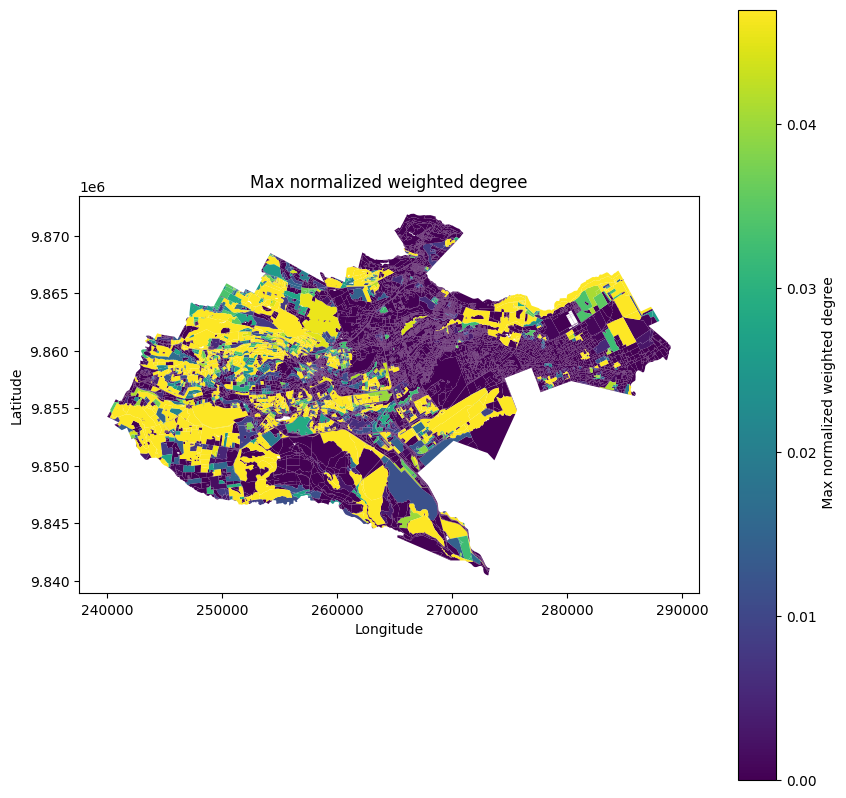

In [ ]:
## Visualize the maximum normalized weighted degree centrality
vmin, vmax = block_gdf['max_normalized_weighted_degree'].quantile([0.05, 0.95])
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
cmap = plt.cm.viridis
block_gdf['facecolor'] = block_gdf['max_normalized_weighted_degree'].apply(lambda x: mcolors.to_hex(cmap(norm(x))))


fig, ax = plt.subplots(figsize=(10, 10))
block_gdf.plot(ax=ax, facecolor=block_gdf['facecolor'], edgecolor='none', linewidth=1)
plt.title('Max normalized weighted degree')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, label=' Max normalized weighted degree')
plt.show()

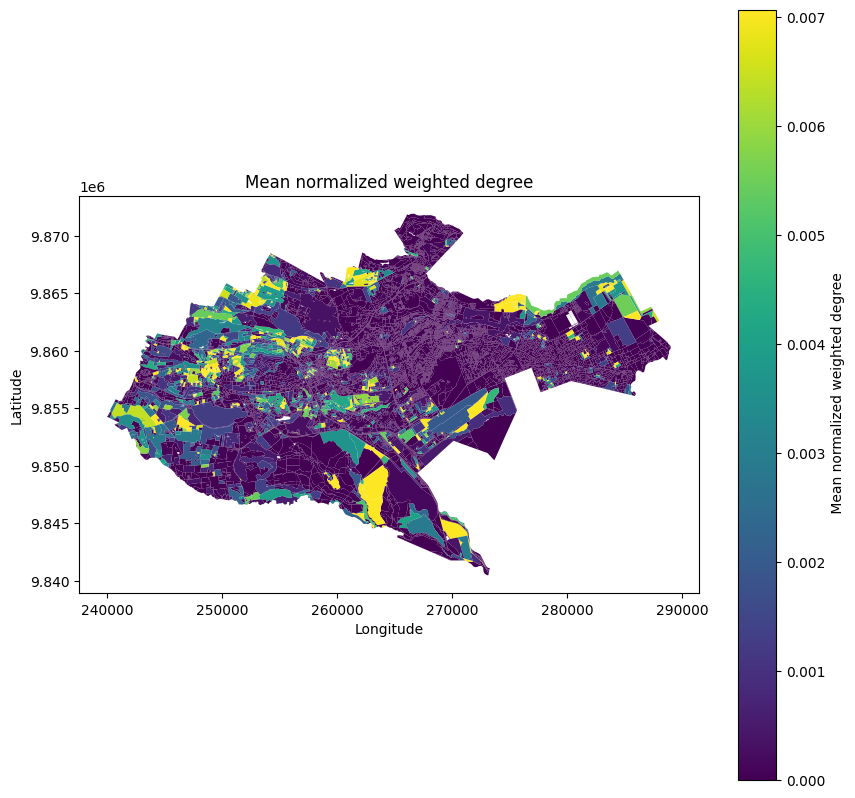

In [ ]:
## Visualize the mean normalized weighted degree centrality
vmin, vmax = block_gdf['mean_normalized_weighted_degree'].quantile([0.05, 0.95])
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
cmap = plt.cm.viridis
block_gdf['facecolor'] = block_gdf['mean_normalized_weighted_degree'].apply(lambda x: mcolors.to_hex(cmap(norm(x))))


fig, ax = plt.subplots(figsize=(10, 10))
block_gdf.plot(ax=ax, facecolor=block_gdf['facecolor'], edgecolor='none', linewidth=1)
plt.title('Mean normalized weighted degree')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, label=' Mean normalized weighted degree')
plt.show()

#Target Variable: DUA locations

In [ ]:
# Load the MajiData GeoJSON file into a GeoDataFrame
slum_map = gpd.read_file('Nairobi_Mahabiretal_2018.geojson')

In [ ]:
# Set CRS to EPSG:32737
slum_map = slum_map.to_crs(epsg=32737)

In [ ]:
#Set a column with all values as 1 that can be merged back into the block dataframe and used as target variable
slum_map['y_Slum'] = 1

In [ ]:
#Droppinng columns that are not required
slum_map=slum_map.drop(columns=['Name', 'description', 'timestamp', 'begin', 'end', 'altitudeMode',
       'tessellate', 'extrude', 'visibility', 'drawOrder', 'icon'])
block_gdf = block_gdf.drop(columns=['level_0'])

In [ ]:
# Perform a spatial join to find which block cells contain geometry from slum_map
slum_grid = gpd.sjoin(block_gdf,slum_map, how='inner', predicate='intersects')

block_gdf = block_gdf.reset_index().merge(slum_grid[['y_Slum','geometry']], how='left', left_on='geometry', right_on='geometry').fillna(0)

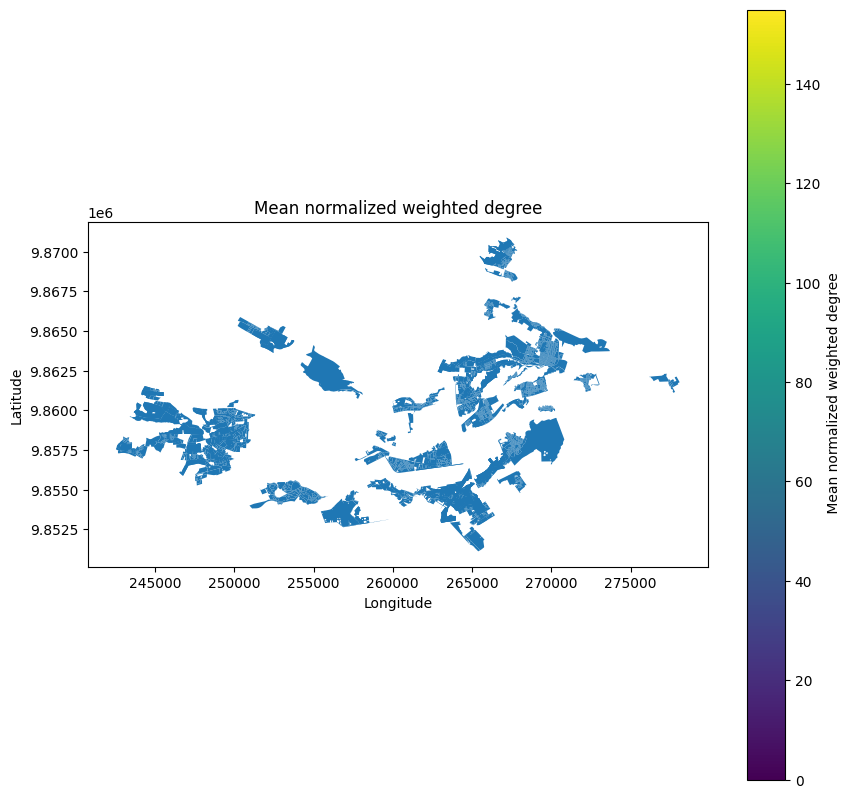

In [ ]:
# Visualize the blocks with DUAs
fig, ax = plt.subplots(figsize=(10, 10))
slum_grid.plot(ax=ax, edgecolor='none', linewidth=1)
plt.title('Blocks with DUAs')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, label=' Blocks with DUAs')
plt.show()

#Target Variable: Armed Conflict locations

In [ ]:
# Load the ACLED csv file into a pandas DataFrame
acled_df = pd.read_csv('ACLED_Extracted+Lat&Long_28thJuly.csv')


In [ ]:
# Ensure the latitude and longitude columns are present
assert 'latitude' in acled_df.columns, "Latitude column not found in the CSV file"
assert 'longitude' in acled_df.columns, "Longitude column not found in the CSV file"

# Convert the latitude and longitude columns to Shapely Point objects
geometry = [Point(xy) for xy in zip(acled_df['Long-Final'], acled_df['Lat-Final'])]

# Create a GeoDataFrame using the points and set the appropriate CRS (assuming WGS84)
acled_gdf = gpd.GeoDataFrame(acled_df, geometry=geometry)
acled_gdf.set_crs(epsg=4326, inplace=True)

# Set CRS to EPSG:32737
acled_gdf = acled_gdf.to_crs(epsg=32737)

print(acled_gdf.head())

  event_id_cnty        event_date  year  time_precision       disorder_type  \
0       KEN8201  21 February 2022  2022               1  Political violence   
1       KEN8201  21 February 2022  2022               1  Political violence   
2       KEN8473     09 April 2022  2022               1      Demonstrations   
3       KEN8473     09 April 2022  2022               1      Demonstrations   
4      KEN13653  12 February 2024  2024               1      Demonstrations   

  event_type             sub_event_type                                actor1  \
0      Riots               Mob violence                       Rioters (Kenya)   
1      Riots               Mob violence  Military Forces of Kenya (2013-2022)   
2   Protests  Protest with intervention                    Protesters (Kenya)   
3   Protests  Protest with intervention    Police Forces of Kenya (2013-2022)   
4   Protests           Peaceful protest                    Protesters (Kenya)   

                              assoc_ac

In [ ]:
#Set a column with all values as 1 that can be merged back into the block dataframe and used as target variable
acled_gdf['y_Conflict'] = 1

In [ ]:
#Drop columns that are not required for downstream analysis
acled_gdf=acled_gdf.drop(columns=['event_id_cnty', 'event_date', 'year', 'time_precision',
       'disorder_type', 'event_type', 'sub_event_type', 'actor1',
       'assoc_actor_1', 'inter1', 'interaction', 'civilian_targeting','iso','region', 'country', 'admin1',
       'admin2', 'admin3', 'location', 'latitude', 'longitude',
       'geo_precision', 'source', 'source_scale', 'notes',
       'Location_extracted', 'Location_extracted+Nairobi','fatalities', 'tags', 'timestamp',
       'population_1km', 'population_2km', 'population_5km', 'population_best','Latitude-Gmaps',
       'Longitude-Gmaps', 'latitude', 'longitude'])
block_gdf = block_gdf.drop(columns=['level_0'])

In [ ]:
# Perform a spatial join to find which grid cells contain geometry from acled_gdf
acled_grid = gpd.sjoin(block_gdf,acled_gdf, how='inner', predicate='intersects')

In [ ]:
# Group by the original grid cell indices to find max values
max_values = acled_grid.groupby('geometry')[['y_Conflict']].max().reset_index()

# Join max values with grid
block_gdf = block_gdf.reset_index().merge(max_values, how='left', left_on='geometry', right_on='geometry').fillna(0)

## Export the block level dataframe with all the features for data preprocessing and analysis


In [ ]:
block_gdf.to_csv('BlockGDF_forDataAnalysis.csv')